In [16]:
import networkx as nx
import netket as nk
from tenpy.models import lattice
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Parameters
m, n = 3, 4  # lattice size

# Basis vectors
a = 1
a1 = np.array([a, 0])
a2 = np.array([a/2, np.sqrt(3)/2 * a])


In [18]:
positions = {}
G = nx.Graph()

for i in range(m):
    for j in range(n):
        node = (i, j)
        pos = i * a1 + j * a2
        positions[node] = (pos[0], pos[1])
        G.add_node(node)

# Add edges for triangular lattice connectivity (3 directions)
for i in range(m):
    for j in range(n):
        node = (i, j)
        # Right neighbor
        if i + 1 < m:
            G.add_edge(node, (i+1, j))
        # Up-right neighbor
        if i + 1 < m and j + 1 < n:
            G.add_edge(node, (i+1, j+1))
        # Up neighbor
        if j + 1 < n:
            G.add_edge(node, (i, j+1))

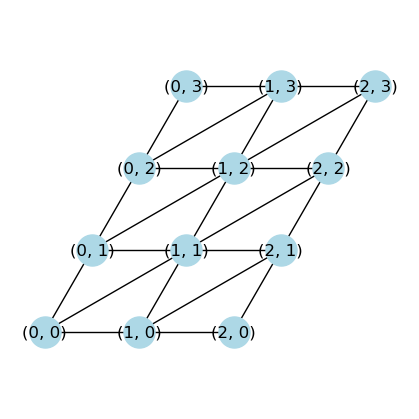

In [19]:
# Plot
plt.figure(figsize=(4,4))
nx.draw(G, positions, with_labels=True, node_color='lightblue', node_size=500)
plt.axis('equal')
plt.show()

In [20]:
# print edges

print(len(G.edges()))

for edge in G.edges():
    print(edge)

23
((0, 0), (1, 0))
((0, 0), (1, 1))
((0, 0), (0, 1))
((0, 1), (1, 1))
((0, 1), (1, 2))
((0, 1), (0, 2))
((0, 2), (1, 2))
((0, 2), (1, 3))
((0, 2), (0, 3))
((0, 3), (1, 3))
((1, 0), (2, 0))
((1, 0), (2, 1))
((1, 0), (1, 1))
((1, 1), (2, 1))
((1, 1), (2, 2))
((1, 1), (1, 2))
((1, 2), (2, 2))
((1, 2), (2, 3))
((1, 2), (1, 3))
((1, 3), (2, 3))
((2, 0), (2, 1))
((2, 1), (2, 2))
((2, 2), (2, 3))


In [21]:
# periodicity

# Add edges for triangular lattice connectivity (3 directions) with periodicity in m
for i in range(m):
    for j in range(n):
        node = (i, j)
        # Right neighbor (periodic in m)
        G.add_edge(node, ((i+1) % m, j))
        # Up-right neighbor (periodic in m)
        G.add_edge(node, ((i+1) % m, j+1))
        # Up neighbor (no periodicity in n yet)
        if j + 1 < n:
            G.add_edge(node, (i, j+1))

# Add edges for triangular lattice connectivity (3 directions) with periodicity in n
for i in range(m):
    for j in range(n):
        node = (i, j)
        # Right neighbor (no periodicity in m yet)
        if i + 1 < m:
            G.add_edge(node, (i+1, j))
        # Up-right neighbor (no periodicity in m yet)
        if i + 1 < m:
            G.add_edge(node, (i+1, (j+1) % n))
        # Up neighbor (periodic in n)
        G.add_edge(node, (i, (j+1) % n))

# Add edges for triangular lattice connectivity (3 directions) with periodicity in both m and n
for i in range(m):
    for j in range(n):
        node = (i, j)
        # Right neighbor (periodic in m)
        G.add_edge(node, ((i+1) % m, j))
        # Up-right neighbor (periodic in both m and n)
        G.add_edge(node, ((i+1) % m, (j+1) % n))
        # Up neighbor (periodic in n)
        G.add_edge(node, (i, (j+1) % n))       

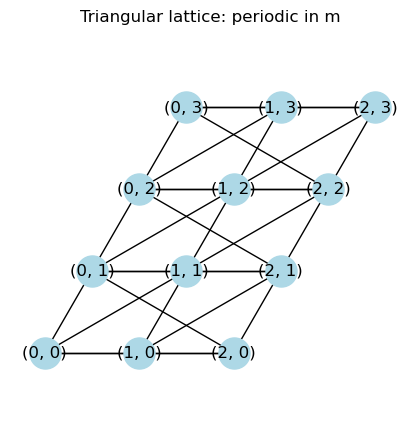

Periodicity in m only:
Number of edges: 30
((0, 0), (1, 0))
((0, 0), (1, 1))
((0, 0), (0, 1))
((0, 0), (2, 0))
((0, 1), (1, 1))
((0, 1), (1, 2))
((0, 1), (0, 2))
((0, 1), (2, 0))
((0, 1), (2, 1))
((0, 2), (1, 2))
((0, 2), (1, 3))
((0, 2), (0, 3))
((0, 2), (2, 1))
((0, 2), (2, 2))
((0, 3), (1, 3))
((0, 3), (2, 2))
((0, 3), (2, 3))
((1, 0), (2, 0))
((1, 0), (2, 1))
((1, 0), (1, 1))
((1, 1), (2, 1))
((1, 1), (2, 2))
((1, 1), (1, 2))
((1, 2), (2, 2))
((1, 2), (2, 3))
((1, 2), (1, 3))
((1, 3), (2, 3))
((2, 0), (2, 1))
((2, 1), (2, 2))
((2, 2), (2, 3))


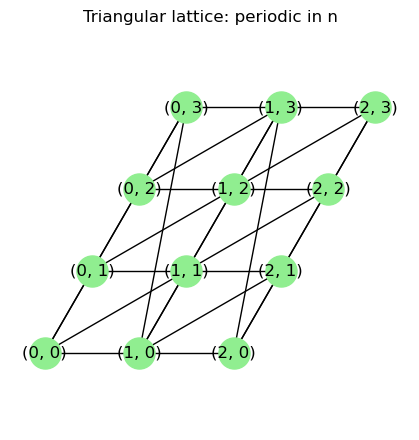


Periodicity in n only:
Number of edges: 28
((0, 0), (1, 0))
((0, 0), (1, 1))
((0, 0), (0, 1))
((0, 0), (0, 3))
((0, 1), (1, 1))
((0, 1), (1, 2))
((0, 1), (0, 2))
((0, 2), (1, 2))
((0, 2), (1, 3))
((0, 2), (0, 3))
((0, 3), (1, 3))
((0, 3), (1, 0))
((1, 0), (2, 0))
((1, 0), (2, 1))
((1, 0), (1, 1))
((1, 0), (1, 3))
((1, 1), (2, 1))
((1, 1), (2, 2))
((1, 1), (1, 2))
((1, 2), (2, 2))
((1, 2), (2, 3))
((1, 2), (1, 3))
((1, 3), (2, 3))
((1, 3), (2, 0))
((2, 0), (2, 1))
((2, 0), (2, 3))
((2, 1), (2, 2))
((2, 2), (2, 3))


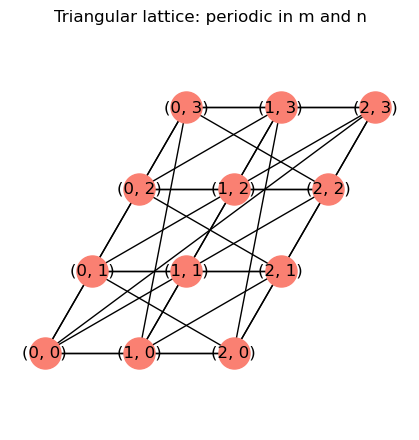


Periodicity in both m and n:
Number of edges: 36
((0, 0), (1, 0))
((0, 0), (1, 1))
((0, 0), (0, 1))
((0, 0), (0, 3))
((0, 0), (2, 0))
((0, 0), (2, 3))
((0, 1), (1, 1))
((0, 1), (1, 2))
((0, 1), (0, 2))
((0, 1), (2, 0))
((0, 1), (2, 1))
((0, 2), (1, 2))
((0, 2), (1, 3))
((0, 2), (0, 3))
((0, 2), (2, 1))
((0, 2), (2, 2))
((0, 3), (1, 3))
((0, 3), (1, 0))
((0, 3), (2, 2))
((0, 3), (2, 3))
((1, 0), (2, 0))
((1, 0), (2, 1))
((1, 0), (1, 1))
((1, 0), (1, 3))
((1, 1), (2, 1))
((1, 1), (2, 2))
((1, 1), (1, 2))
((1, 2), (2, 2))
((1, 2), (2, 3))
((1, 2), (1, 3))
((1, 3), (2, 3))
((1, 3), (2, 0))
((2, 0), (2, 1))
((2, 0), (2, 3))
((2, 1), (2, 2))
((2, 2), (2, 3))


In [22]:
# --- Periodicity in m only ---
Gm = nx.Graph()
for i in range(m):
    for j in range(n):
        node = (i, j)
        pos = i * a1 + j * a2
        Gm.add_node(node, pos=(pos[0], pos[1]))
for i in range(m):
    for j in range(n):
        node = (i, j)
        Gm.add_edge(node, ((i+1) % m, j))
        if j + 1 < n:
            Gm.add_edge(node, ((i+1) % m, j+1))
            Gm.add_edge(node, (i, j+1))
plt.figure(figsize=(4,4))
nx.draw(Gm, {n: d['pos'] for n, d in Gm.nodes(data=True)}, with_labels=True, node_color='lightblue', node_size=500)
plt.title("Triangular lattice: periodic in m")
plt.axis('equal')
plt.show()
print("Periodicity in m only:")
print("Number of edges:", len(Gm.edges()))
for edge in Gm.edges():
    print(edge)

# --- Periodicity in n only ---
Gn = nx.Graph()
for i in range(m):
    for j in range(n):
        node = (i, j)
        pos = i * a1 + j * a2
        Gn.add_node(node, pos=(pos[0], pos[1]))
for i in range(m):
    for j in range(n):
        node = (i, j)
        if i + 1 < m:
            Gn.add_edge(node, (i+1, j))
            Gn.add_edge(node, (i+1, (j+1) % n))
        Gn.add_edge(node, (i, (j+1) % n))
plt.figure(figsize=(4,4))
nx.draw(Gn, {n: d['pos'] for n, d in Gn.nodes(data=True)}, with_labels=True, node_color='lightgreen', node_size=500)
plt.title("Triangular lattice: periodic in n")
plt.axis('equal')
plt.show()
print("\nPeriodicity in n only:")
print("Number of edges:", len(Gn.edges()))
for edge in Gn.edges():
    print(edge)

# --- Periodicity in both m and n ---
Gmn = nx.Graph()
for i in range(m):
    for j in range(n):
        node = (i, j)
        pos = i * a1 + j * a2
        Gmn.add_node(node, pos=(pos[0], pos[1]))
for i in range(m):
    for j in range(n):
        node = (i, j)
        Gmn.add_edge(node, ((i+1) % m, j))
        Gmn.add_edge(node, ((i+1) % m, (j+1) % n))
        Gmn.add_edge(node, (i, (j+1) % n))
plt.figure(figsize=(4,4))
nx.draw(Gmn, {n: d['pos'] for n, d in Gmn.nodes(data=True)}, with_labels=True, node_color='salmon', node_size=500)
plt.title("Triangular lattice: periodic in m and n")
plt.axis('equal')
plt.show()
print("\nPeriodicity in both m and n:")
print("Number of edges:", len(Gmn.edges()))
for edge in Gmn.edges():
    print(edge)

List of bonds (edges):
((0, 0), (1, 0))
((0, 0), (0, 1))
((0, 0), (0, 3))
((0, 0), (2, 0))
((0, 0), (2, 1))
((0, 0), (2, 3))
((1, 0), (2, 0))
((1, 0), (1, 1))
((1, 0), (0, 1))
((1, 0), (0, 3))
((1, 0), (1, 3))
((2, 0), (2, 1))
((2, 0), (1, 1))
((2, 0), (1, 3))
((2, 0), (2, 3))
((0, 1), (1, 1))
((0, 1), (0, 2))
((0, 1), (1, 2))
((0, 1), (2, 1))
((1, 1), (2, 1))
((1, 1), (1, 2))
((1, 1), (2, 2))
((2, 1), (2, 2))
((2, 1), (0, 2))
((0, 2), (1, 2))
((0, 2), (0, 3))
((0, 2), (2, 2))
((0, 2), (2, 3))
((1, 2), (2, 2))
((1, 2), (1, 3))
((1, 2), (0, 3))
((2, 2), (2, 3))
((2, 2), (1, 3))
((0, 3), (1, 3))
((0, 3), (2, 3))
((1, 3), (2, 3))


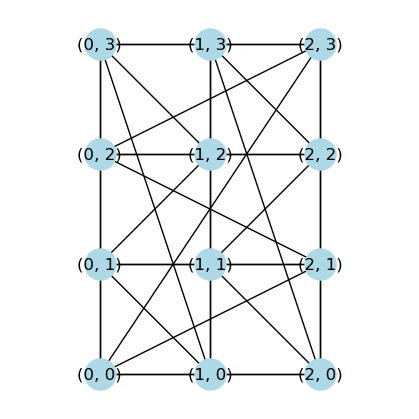

In [23]:
# Create a 3x3 periodic triangular lattice
G = nx.generators.lattice.triangular_lattice_graph(4, 6, periodic=True)

# Print a list of bonds (edges)
print("List of bonds (edges):")
for edge in G.edges():
    print(edge)

# Plot
plt.figure(figsize=(4,4))
nx.draw(G, pos=dict((n, n) for n in G.nodes()), with_labels=True, node_color='lightblue', node_size=500)
plt.axis('equal')
plt.show()

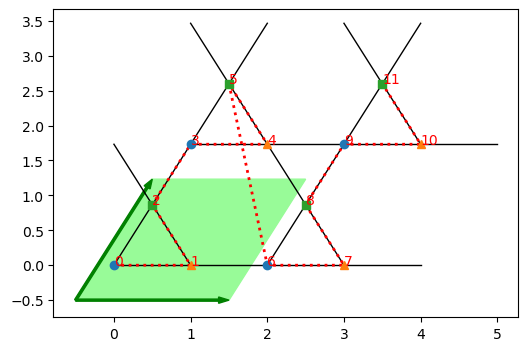

In [32]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
lat = lattice.Kagome(2, 2, None, bc='periodic')
lat.plot_coupling(ax, linestyle='-', linewidth=1)
lat.order = lat.ordering('default')
lat.plot_order(ax, linestyle=':', linewidth=2)
lat.plot_sites(ax)
lat.plot_basis(ax, origin=(-0.5, -0.5))
plt.show()

In [33]:
# Print a list of nodes + bonds

# Print nodes and bonds
print("List of nodes (sites):")
print(lat.N_sites)
print("\nList of bonds (edges):")
for bond in lat.possible_couplings():
    print(bond)

List of nodes (sites):
12

List of bonds (edges):


TypeError: Lattice.possible_couplings() missing 3 required positional arguments: 'u1', 'u2', and 'dx'